# Predicting Age from National Health and Nutrition Health Survey 2013-2014

by Ismail (Husain) Bhinderwala, Rashid Mammadov, Sienko Ikhabi, Dongchun Chen

# Summary

Add summary 

# Introduction

- provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report
- clearly state the question you tried to answer with your project
- identify and describe the dataset that was used to answer the question


# Methods and Results

- describe in written english the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.
- your report should include code which:
- loads data from the original source on the web
- wrangles and cleans the data from it’s original (downloaded) format to the format necessary for the planned classification or clustering analysis
- performs a summary of the data set that is relevant for exploratory data analysis related to the planned classification analysis
- creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned classification analysis
- performs classification or regression analysis
- creates a visualization of the result of the analysis
- note: all tables and figure should have a figure/table number and a legend

In [1]:
import numpy as np
import requests
import zipfile
import os
import pandas as pd
import altair as alt
from sklearn.model_selection import train_test_split
from sklearn import set_config

In [2]:
# downloading data as zip and extracting
url = "https://archive.ics.uci.edu/static/public/887/national+health+and+nutrition+health+survey+2013-2014+(nhanes)+age+prediction+subset.zip"

request = requests.get(url)
with open("../data/raw/national+health+and+nutrition+health+survey+2013-2014+(nhanes)+age+prediction+subset.zip", 'wb') as f:
    f.write(request.content)

with zipfile.ZipFile("../data/raw/national+health+and+nutrition+health+survey+2013-2014+(nhanes)+age+prediction+subset.zip", 'r') as zip_ref:
    zip_ref.extractall("../data/raw")

In [3]:
# pre-processing data
col_names = [
    "id",
    "age_group",
    "age",
    "gender",
    "weekly_physical_activity",
    "bmi",
    "blood_glucose_fasting",
    "diabetic",
    "oral",
    "insulin_level"
]

data = pd.read_csv("../data/raw/NHANES_age_prediction.csv", names=col_names, skiprows=1).drop(columns=["id","age"])

data["gender"] = data["gender"].replace({
    1 : "Male",
    2 : "Female"
})

data["weekly_physical_activity"] = data["weekly_physical_activity"].replace({
    1 : "Yes",
    2 : "No"
})

data["diabetic"] = data["diabetic"].replace({
    1 : "Yes",
    2 : "No",
    3 : "Borderline"
})

data

,age_group,gender,weekly_physical_activity,bmi,blood_glucose_fasting,diabetic,oral,insulin_level
0,Adult,Female,No,35.7,110.0,No,150.0,14.91
1,Adult,Female,No,20.3,89.0,No,80.0,3.85
2,Adult,Male,No,23.2,89.0,No,68.0,6.14
3,Adult,Male,No,28.9,104.0,No,84.0,16.15
4,Adult,Female,Yes,35.9,103.0,No,81.0,10.92
...,...,...,...,...,...,...,...,...
2273,Adult,Female,No,33.5,100.0,No,73.0,6.53
2274,Adult,Male,No,30.0,93.0,No,208.0,13.02
2275,Adult,Male,No,23.7,103.0,No,124.0,21.41
2276,Adult,Female,No,27.4,90.0,No,108.0,4.99


In [4]:
data.describe()

,bmi,blood_glucose_fasting,oral,insulin_level
count,2278.000000,2278.000000,2278.000000,2278.000000
mean,27.955180,99.553117,114.978929,11.834794
std,7.248962,17.889834,47.061239,9.718812
min,14.500000,63.000000,40.000000,0.140000
25%,22.800000,91.000000,87.000000,5.860000
50%,26.800000,97.000000,105.000000,9.040000
75%,31.200000,104.000000,130.000000,14.440000
max,70.100000,405.000000,604.000000,102.290000


In [5]:
data["age_group"].value_counts() #target variable
#class imbalance in the data

age_group
Adult     1914
Senior     364
Name: count, dtype: int64

In [6]:
data["gender"].value_counts()

gender
Female    1165
Male      1113
Name: count, dtype: int64

In [7]:
data["weekly_physical_activity"].value_counts()

weekly_physical_activity
No     1868
Yes     409
7.0       1
Name: count, dtype: int64

In [8]:
data["diabetic"].value_counts()

diabetic
No            2199
Borderline      58
Yes             21
Name: count, dtype: int64

In [10]:
np.random.seed(522)
set_config(transform_output="pandas")

# creating the train test split
data_train, data_test = train_test_split(
    data, train_size=0.75, stratify=data["age_group"] #using stratify for class imbalance in target variable
)

# set path name variables
file_data_dir = '../data'
file_data_train = os.path.join(file_data_dir, 'processed', 'data_train.csv')
file_data_test = os.path.join(file_data_dir, 'processed', 'data_test.csv')

data_train.to_csv(file_data_train, index = False)
data_test.to_csv(file_data_test, index = False)

# Model Development

## Model Definition

In [27]:
# Modelling imports
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)

In [16]:
#Load the training data
data_train = pd.read_csv(file_data_train)


In [31]:
# data columns
numeric_features = ['bmi', 'blood_glucose_fasting', 'oral', 'insulin_level']
categorical_features = ['weekly_physical_activity', 'gender']
ordinal_features = ['diabetic']
binary_features = []
drop_features = []
target = 'age_group'

# separate the features
X_train, y_train = data_train.drop(columns = [target]), data_train[target]


In [32]:

# numeric columns
numeric_transformer = StandardScaler()

#ordinal column
diabetic_levels = ['No', 'Borderline', 'Yes']
ordinal_transformer = OrdinalEncoder(categories=[diabetic_levels], dtype = int)

#Binary
binary_transformer = OneHotEncoder(drop = 'if_binary', dtype = int)

#create categorical pipeline
categorical_transformer = make_pipeline(
    SimpleImputer(strategy = 'constant', fill_value = 'missing'), 
    OneHotEncoder(handle_unknown = 'ignore', sparse_output = False)
)

In [33]:
preprocessor = make_column_transformer(
    # transformer for numeric features
    (numeric_transformer, numeric_features),
    # ordinal transformer
    (ordinal_transformer, ordinal_features),
    # binary one hot encoding
    (binary_transformer, binary_features),
    #categorical features
    (categorical_transformer, categorical_features),
    #features to drop/not use
    ("drop", drop_features), 
)

# view the transformers
preprocessor

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['bmi', 'blood_glucose_fasting', 'oral',
                                  'insulin_level']),
                                ('ordinalencoder',
                                 OrdinalEncoder(categories=[['No', 'Borderline',
                                                             'Yes']],
                                                dtype=<class 'int'>),
                                 ['diabetic']),
                                ('onehotencoder',
                                 OneHotEncoder(drop='if_binary',
                                               dtype=<class 'int'>),
                                 []),
                                ('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['weekly_physical_activity', 'gender']),
                                ('drop', 'drop', [])])

In [39]:
lgr_classifier = LogisticRegression(max_iter = 2000, 
                                       random_state = 123)
pipe = make_pipeline(preprocessor, lgr_classifier)

## Model Fitting

In [34]:
# Ref: mean_std_cross_val_scores from DSCI 571 Lecture notes
#   Author: Varada Kolhatkar 

def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores.iloc[i], std_scores.iloc[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [44]:
results_dict = {} 
results_dict["logistic regression"] = mean_std_cross_val_scores(
    pipe, X_train, y_train, cv = 5, return_train_score = True
)
results_df = pd.DataFrame(results_dict).T
results_df

,fit_time,score_time,test_score,train_score
logistic regression,0.016 (+/- 0.003),0.007 (+/- 0.001),0.839 (+/- 0.005),0.839 (+/- 0.002)


In [45]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['bmi',
                                                   'blood_glucose_fasting',
                                                   'oral', 'insulin_level']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['No',
                                                                              'Borderline',
                                                                              'Yes']],
                                                                 dtype=<class 'int'>),
                                                  ['diabetic']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                dtype=<class 'int'>),
                                                  []),
                                                 ('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['weekly_physical_activity',
                                                   'gender']),
                                                 ('drop', 'drop', [])])),
                ('logisticregression',
                 LogisticRegression(max_iter=2000, random_state=123))])

## Model Evaluation

In [52]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [55]:
# Load test data
data_test = pd.read_csv(file_data_test)
X_test, y_test = data_test.drop(columns = [target]), data_test[target]

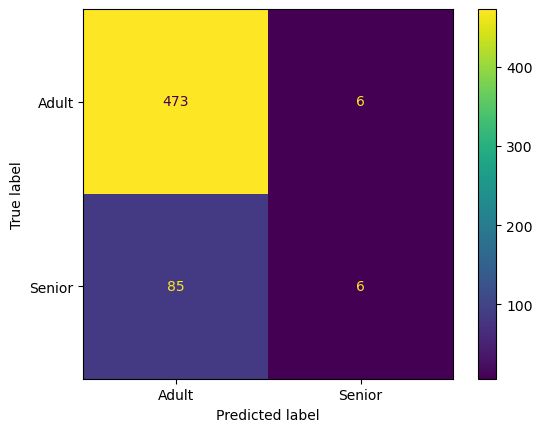

In [56]:
ConfusionMatrixDisplay.from_predictions(
    y_test, 
    cross_val_predict(pipe, X_test, y_test),  
    values_format = 'd'  
)

In [57]:
print(
    classification_report(
        y_train, pipe.predict(X_train)
    )
)

              precision    recall  f1-score   support

       Adult       0.85      0.99      0.91      1435
      Senior       0.45      0.06      0.11       273

    accuracy                           0.84      1708
   macro avg       0.65      0.52      0.51      1708
weighted avg       0.78      0.84      0.78      1708



In [2]:
# Start model building from here (Sienko)

# Discussion

- summarize what you found
- discuss whether this is what you expected to find?
- discuss what impact could such findings have?
- discuss what future questions could this lead to?

# References

NA N. National Health and Nutrition Health Survey 2013-2014 (NHANES) Age Prediction Subset [dataset]. 2019. UCI Machine Learning Repository. Available from: https://doi.org/10.24432/C5BS66.

Harris CR, Millman KJ, Van Der Walt SJ, Gommers R, Virtanen P, Cournapeau D, Wieser E, Taylor J, Berg S, Smith NJ, Kern R. Array programming with NumPy. Nature. 2020 Sep 17;585(7825):357-62.

VanderPlas J, Granger B, Heer J, Moritz D, Wongsuphasawat K, Satyanarayan A, Lees E, Timofeev I, Welsh B, Sievert S. Altair: interactive statistical visualizations for Python. Journal of open source software. 2018 Dec 10;3(32):1057.

Pedregosa F. Scikit‐learn: Machine learning in python Fabian. Journal of machine learning research. 2011;12:2825.

Van Rossum G, Drake FL. Introduction to python 3: python documentation manual part 1. CreateSpace; 2009 Mar 20.